Libraries

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft,dct
import librosa
from scipy import signal
import soundfile as sf
from librosa.display import specshow
import glob

Importing data

In [80]:
# # separate 

carTrain = glob.glob("cars/train/*.wav")
carTest = glob.glob("cars/test/*.wav")

tramTrain = glob.glob("trams/train/*.wav")
tramTest = glob.glob("trams/test/*.wav")

dataset=[]
labels = []


In [81]:
def importFiles(files, label):
    dataset = []
    labels = []
    for file in files:
        data,sr = librosa.load(file)
        data = librosa.effects.trim(data, top_db=20, frame_length=1024, hop_length=512)[0] 
        # print(data.size)
        # print(data.shape)# Desired length in samples
        desired_length = sr * 5
        # # Initialize a new array of zeros with the desired length
        fixed_length_data = np.zeros(desired_length)
        #  Check the length of the original data
        original_length = len(data)
        # # If original data is longer than desired length, truncate it
        # # If it is shorter, pad with zeros
        if original_length > desired_length:
            fixed_length_data = data[:desired_length]
        else:
            fixed_length_data[:original_length] = data
        # # Now use fixed_length_data as your adjusted data
        data = fixed_length_data




        labels.append(label)
        dataset.append(data)

    return dataset,labels

In [82]:
# # separate

car_dataset, car_label  = importFiles(carTrain, 0)
car_test_dataset, car_test_label = importFiles(carTest, 0)
tram_dataset, tram_label = importFiles(tramTrain, 1)
tram_test_dataset, tram_test_label = importFiles(tramTest, 1)

/tmp/ipykernel_171569/3366563929.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  data,sr = librosa.load(file)
/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [83]:
tram_dataset_array = np.array(tram_dataset)
car_dataset_array = np.array(car_dataset)
tram_label_array = np.array(tram_label)
car_label_array = np.array(car_label)


In [84]:
dataset = np.concatenate([tram_dataset, car_dataset], axis=0)
labels = np.concatenate([tram_label, car_label], axis=0)


In [85]:
dataset_test = np.concatenate([tram_test_dataset,car_test_dataset], axis=0)
labels_test = np.concatenate([tram_test_label, car_test_label], axis=0)


Feature Extraction

In [238]:
def padding(data, target_height, target_width):
    h = data.shape[0]
    w = data.shape[1]
    
    a = max((target_height - h) // 2,0)
    aa = max(0,target_height - a - h)
    
    b = max(0,(target_width - w) // 2)
    bb = max(target_width - b - w,0)
    
    return np.pad(data, pad_width=((a, aa), (b, bb)), mode='constant')

In [263]:
fs = 44000
f2=[]

def extractFeatures(dataset, model="KNN"):
    features = []
    max_size = 1000
    
    for audio in dataset:
        mfccs = librosa.feature.mfcc(y=np.asarray(audio), sr=fs, n_mfcc=50)
    
        # spectral spread
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=np.asarray(audio), sr=fs)

        # spectral energy
        spectral_centroid = librosa.feature.spectral_centroid(y=np.asarray(audio), sr=fs)

        # spectral density
        spectral_contrast = librosa.feature.spectral_contrast(y=np.asarray(audio), sr=fs)

        #  rate of sign-changes in the signal
        zerocrossing_rate = librosa.feature.zero_crossing_rate(y=np.asarray(audio))

        #  frequency below which a certain percentage of the power spectrum is concentrated
        spectral_rolloff = librosa.feature.spectral_rolloff(y=np.asarray(audio), sr=fs)
        
        # combined_features = np.hstack([np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
        #                                np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
        #                                np.mean(spectral_centroid), np.std(spectral_centroid),
        #                                np.mean(spectral_contrast), np.std(spectral_contrast),
        #                                np.mean(zerocrossing_rate), np.std(zerocrossing_rate),
        #                                np.mean(spectral_rolloff), np.std(spectral_rolloff)])
        
        # combined_features_for_CNN = np.hstack([spectral_bandwidth, spectral_centroid])
        # combined_features_for_CNN2= np.hstack([zerocrossing_rate, spectral_rolloff])
        # combined_features2=np.vstack([combined_features_for_CNN,combined_features_for_CNN2])

        if model == "KNN":
            # combined features include spectral bandwidth, spectral centroid, zero-crossing rate, spectral rolloff
            mfccs = np.reshape(mfccs, (1,-1))
            spectral_contrast = np.reshape(spectral_contrast, (1,-1))
            combined_features = np.hstack([spectral_bandwidth, spectral_centroid, zerocrossing_rate, spectral_rolloff, mfccs, spectral_contrast])
            features.append(combined_features)
        else:
            combined_features = np.vstack([padding(spectral_bandwidth, 1, max_size),
                                           padding(spectral_centroid, 1, max_size),
                                           padding(zerocrossing_rate, 1, max_size), 
                                           padding(spectral_rolloff, 1, max_size),
                                           padding(spectral_contrast, 1, max_size)])
            for i in range(0,mfccs.shape[0]):
                combined_features = np.append(combined_features, padding(spectral_bandwidth, 1, max_size), axis=0)
                combined_features = np.append(combined_features, padding(spectral_centroid, 1, max_size), axis=0)
                combined_features = np.append(combined_features, padding(zerocrossing_rate, 1, max_size), axis=0)
                combined_features = np.append(combined_features, padding(spectral_rolloff, 1, max_size), axis=0)
                combined_features = np.append(combined_features, padding(spectral_contrast, 1, max_size), axis=0)
            
                if combined_features.shape[0] > mfccs.shape[0]:
                    difference = combined_features.shape[0] - mfccs.shape[0]
                    combined_features = combined_features[:-difference, :]
                    break
                
                
            combined_features = np.dstack((combined_features, padding(mfccs, mfccs.shape[0], max_size)))
            
            features.append(combined_features)

    features = np.array(features)
    return features

In [230]:
features = extractFeatures(dataset)

In [264]:
features2 =extractFeatures(dataset,"CNN")

In [150]:
len(features)

146

In [136]:
features_test=extractFeatures(dataset_test,"KNN")
# features_test2=extractFeatures(dataset_test,"CNN")

In [174]:
# fs = 44000
# features=[]
# features2=[]
# f2=[]

# for audio in dataset:
#     mfcc = librosa.feature.mfcc(y=np.asarray(audio), sr=fs, n_mfcc=50)    
#     # spectral spread
#     spectral_bandwidth = librosa.feature.spectral_bandwidth(y=np.asarray(audio), sr=fs)

#     # spectral energy
#     spectral_centroid = librosa.feature.spectral_centroid(y=np.asarray(audio), sr=fs)

#     # spectral density
#     spectral_contrast = librosa.feature.spectral_contrast(y=np.asarray(audio), sr=fs)

#     #  rate of sign-changes in the signal
#     zerocrossing_rate = librosa.feature.zero_crossing_rate(y=np.asarray(audio))

#     #  frequency below which a certain percentage of the power spectrum is concentrated
#     spectral_rolloff = librosa.feature.spectral_rolloff(y=np.asarray(audio), sr=fs)

#     combined_features = np.hstack([np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
#                                    np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
#                                    np.mean(spectral_centroid), np.std(spectral_centroid),
#                                    np.mean(spectral_contrast), np.std(spectral_contrast),
#                                    np.mean(zerocrossing_rate), np.std(zerocrossing_rate),
#                                    np.mean(spectral_rolloff), np.std(spectral_rolloff)])
    
#     combined = np.hstack([spectral_bandwidth, spectral_centroid])
#     combo= np.hstack([zerocrossing_rate, spectral_rolloff])
#     co=np.vstack([combined,combo])
#     f2.append(co)

#     # #combined = np.concatenate(mfcc,spectral_bandwidth, spectral_centroid, spectral_contrast, zerocrossing_rate, spectral_rolloff)
#     # x=spectral_bandwidth.shape

#     combined_features_2d = combined_features.reshape(1, -1)

#     # Append combined features as 2D array
#     features.append(combined_features_2d)
#     #features2.append(f2)

#     #features.append(combined_features)
#     features2.append(mfcc)


In [224]:
features = np.asarray(features)
# features2= np.asarray(features2)

In [138]:
features_test= np.asarray(features_test)
# features_test2= np.asarray(features_test2)

In [139]:
print(features.shape)
# print(features2.shape)

(146, 1, 864)


In [140]:
features_knn = features.reshape((146,-1))
print(features_knn.shape)

(146, 864)


Nearest Neighbour

In [231]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [233]:
# # all
from sklearn.metrics import accuracy_score, precision_score, recall_score

# change is needed here: 
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(precision)
print(recall)
print(accuracy)


0.8461538461538461
0.6111111111111112
0.7


CNN

In [267]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [269]:
## original model
input_shape = (2, 432, 1)
# input_shape = (50,1000,1)

model = Sequential()
model.add(Conv2D(4, kernel_size=(2,2), activation='relu', input_shape=input_shape))
#model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 49, 999, 4)        36        
                                                                 
 flatten_7 (Flatten)         (None, 195804)            0         
                                                                 
 dense_22 (Dense)            (None, 16)                3132880   
                                                                 
 dense_23 (Dense)            (None, 8)                 136       
                                                                 
 dense_24 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3133061 (11.95 MB)
Trainable params: 3133061 (11.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [275]:
## alternative model
input_shape = (50,1000,2)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 998, 32)       608       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 499, 32)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 499, 32)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 22, 497, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 11, 248, 64)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 11, 248, 64)     

In [276]:
X_train, X_test, y_train, y_test = train_test_split(features2, labels, test_size=0.2, random_state=42)

In [278]:
history = model.fit(x=X_train,y=y_train,epochs=20)

Epoch 1/20


2023-12-15 17:42:06.025864: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/traitlets/config/application.py", line 1053, in launch_instance
      app.start()
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 737, in start
      self.io_loop.start()
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell
      await result
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_171569/2161489901.py", line 1, in <module>
      history = model.fit(x=X_train,y=y_train,epochs=10)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/keras/src/engine/training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/keras/src/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/keras/src/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/keras/src/losses.py", line 2354, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/keras/src/backend.py", line 5762, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_11887]

In [109]:
output= model.predict(features_test)

2/2 [==============================] - 0s 18ms/step


In [110]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
predictions = [1 if x > 0.5 else 0 for x in output]

accuracy2 = accuracy_score(labels_test, predictions)
precision2 = precision_score(labels_test, predictions)
recall2 = recall_score(labels_test, predictions)


Results

In [121]:
print("Nearest Neighbour:")
print("Precision:", precision)
print("Recall:", recall)

print("CNN:")
print("Accuracy:", accuracy2)
print("Precision:", precision2)
print("Recall:", recall2)

Nearest Neighbour:
Precision: 0.8461538461538461
Recall: 0.6111111111111112
CNN:
Accuracy: 0.4444444444444444
Precision: 0.4444444444444444
Recall: 1.0


### Feature analysis

Spectral Bandwidth

In [74]:
def extractIndividualFeatures(dataset):
    mfcc_feat = []
    spectral_bandwidth_feat = [] 
    spectral_centroid_feat = []
    spectral_contrast_feat = []
    zerocrossing_rate_feat = []
    spectral_rolloff_feat = []

    for audio in dataset:
        mfccs = librosa.feature.mfcc(y=np.asarray(audio), sr=fs, n_mfcc=50, n_fft = 512)
        mfcc_feat.append(mfccs)
        
        # spectral spread
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=np.asarray(audio), sr=fs)

        # spectral energy
        spectral_centroid = librosa.feature.spectral_centroid(y=np.asarray(audio), sr=fs)

        # spectral density
        spectral_contrast = librosa.feature.spectral_contrast(y=np.asarray(audio), sr=fs)
        spectral_contrast_feat.append(spectral_contrast)

        #  rate of sign-changes in the signal
        zerocrossing_rate = librosa.feature.zero_crossing_rate(y=np.asarray(audio))

        #  frequency below which a certain percentage of the power spectrum is concentrated
        spectral_rolloff = librosa.feature.spectral_rolloff(y=np.asarray(audio), sr=fs)

        spectral_bandwidth_feat.append(spectral_bandwidth)
        spectral_centroid_feat.append(spectral_centroid)
        zerocrossing_rate_feat.append(zerocrossing_rate)
        spectral_rolloff_feat.append(spectral_rolloff)

    # for audio in dataset:
    #     mfccs = librosa.feature.mfcc(y=np.asarray(audio), sr=fs, n_mfcc=50)
    
    #     # spectral spread
    #     spectral_bandwidth = librosa.feature.spectral_bandwidth(y=np.asarray(audio), sr=fs)

    #     # spectral energy
    #     spectral_centroid = librosa.feature.spectral_centroid(y=np.asarray(audio), sr=fs)

    #     # spectral density
    #     spectral_contrast = librosa.feature.spectral_contrast(y=np.asarray(audio), sr=fs)

    #     #  rate of sign-changes in the signal
    #     zerocrossing_rate = librosa.feature.zero_crossing_rate(y=np.asarray(audio))

    #     #  frequency below which a certain percentage of the power spectrum is concentrated
    #     spectral_rolloff = librosa.feature.spectral_rolloff(y=np.asarray(audio), sr=fs)

    #     mfcc_feat.append(mfccs)
    #     spectral_bandwidth_feat.append(spectral_bandwidth)
    #     spectral_centroid_feat.append(spectral_centroid)
    #     spectral_contrast_feat.append(spectral_contrast)
    #     zerocrossing_rate_feat.append(zerocrossing_rate)
    #     spectral_rolloff_feat.append(spectral_rolloff)

    other_features = np.hstack([spectral_bandwidth_feat, spectral_centroid_feat, zerocrossing_rate_feat, spectral_rolloff_feat])
    mfcc_feat = np.asarray(mfcc_feat)
    spectral_contrast_feat = np.asarray(spectral_contrast_feat)
    
    return mfcc_feat, spectral_contrast_feat, other_features

In [75]:
tram_mfcc, tram_spectral_contrast, tram_other_features = extractIndividualFeatures(tram_dataset_array)
# mfcc_feat, spectral_bandwidth_feat, spectral_centroid_feat, spectral_contrast_feat, zerocrossing_rate_feat, spectral_rolloff_feat = extractIndividualFeatures(tram_dataset_array)

/home/smitty/miniconda3/envs/audioproc/lib/python3.8/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [69]:
# avg_tram_mfcc = np.mean(tram_mfcc, axis=1)

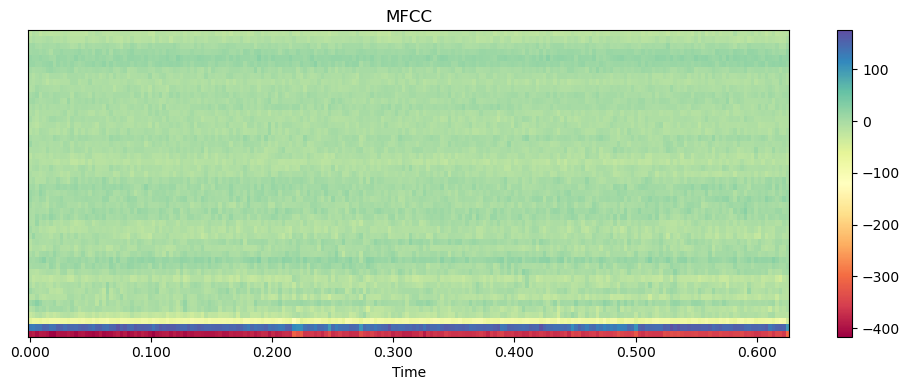

In [78]:
## MFCC and Spectral contrast data is in shape (x,y,z), 
## where x = number of audio files, and (y,z) is the shape of MFCC and spectral contrast for each audio

plt.figure(figsize=(10, 4))
librosa.display.specshow(tram_mfcc[25],cmap='Spectral', x_axis='time',sr=fs, hop_length=128)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()